In [75]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from argparse import Namespace
from pathlib import Path
import pandas as pd
import pyarrow
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from collections import Counter
from nltk import ngrams
import string
import re

## Arguments

In [76]:
args = Namespace()
args.country_code='US'
args.model_folder='iter_0-convbert-969622-evaluation'
args.model_type='paraphrase-xlm-r-multilingual-v1'

## Define base rates

In [77]:
labels=['is_hired_1mo', 'is_unemployed', 'job_offer', 'job_search', 'lost_job_1mo']

base_rates_old = {'US': [5.71e-5, 1.18e-5, 8.82e-4, 3.38e-5, 4.43e-6]}

base_rates={'US':
[5.97e-5, 3.03e-5,8.82e-4, 6.19e-5, 6.65e-6 ],
#past values
#6.91e-05,
#1.18e-05,
#2.28e-03,
#3.51e-05,
#5.44e-06],
'MX': [2.73e-05, 1.11e-05, 1.77e-04, 8.36e-06, 1.64e-06],
'BR': [7.52e-06, 1.51e-05, 1.43e-04, 2.86e-05, 3.6e-06]}

N_random={'US':100002226, 'MX': 99998628, 'BR': 99984967 }


base_ranks=[int(x*N_random[args.country_code]) for x in base_rates[args.country_code]]
label2rank=dict(zip(labels,base_ranks))

In [78]:
model = SentenceTransformer(args.model_type)

## Utils

In [79]:
random_set_dir = Path(f'/scratch/mt4493/twitter_labor/twitter-labor-data/data/random_samples/random_samples_splitted/{args.country_code}/evaluation')
text_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in random_set_dir.glob('*.parquet')
)

KeyboardInterrupt: 

In [80]:
scores_folder = f'/scratch/mt4493/twitter_labor/twitter-labor-data/data/inference/{args.country_code}/{args.model_folder}/output'

In [81]:
def load_scores(label):
    scores_dir = Path(os.path.join(scores_folder, label))
    scores_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in scores_dir.glob('*.parquet')
    )
    return scores_df

In [82]:
def get_elbow_graph(embeddings):
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(embeddings)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [101]:
def perform_k_means(embeddings, num_clusters, corpus_df):
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    cluster_assignment = clustering_model.labels_
    clustered_sentences = [[] for i in range(num_clusters)]
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clustered_sentences[cluster_id].append(corpus_df['text'].tolist()[sentence_id])
    return clustered_sentences, cluster_assignment

In [84]:
def get_most_common_ngrams(tweet_list, n, topk):
    tweet_str = " ".join(tweet_list)
    for character in string.punctuation:
        tweet_str = tweet_str.replace(character, " ")
    tweet_str = tweet_str.lower()
    tweet_str = re.sub('http\S+', ' ', tweet_str)
    ngram_counts = Counter(ngrams(tweet_str.split(), n))
    return ngram_counts.most_common(topk)

In [85]:
def clean_tweets(tweet_list):
    return [re.sub('http\S+', ' ', tweet_str) for tweet_str in tweet_list]        

In [86]:
def merge_df_top_tweets(text_df, scores_df, label):
    merged_df = scores_df.merge(text_df, on="tweet_id", how='inner')
    merged_df['rank'] = merged_df['score'].rank(method='dense', ascending=False)
    merged_df = merged_df.loc[merged_df['rank']<label2rank['lost_job_1mo']]
    return merged_df

In [ ]:
folder_path = '/scratch/mt4493/twitter_labor/twitter-labor-data/data/top_tweets'
output_path = os.path.join(folder_path, args.country_code, args.model_folder)
for label in labels:
    print(label)
    scores_df = load_scores(label)
    merged_df = merge_df_top_tweets(text_df, scores_df, label)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    merged_df.to_parquet(os.path.join(output_path, f'{label}.parquet'), index=False)

# lost_job_1mo

In [87]:
merged_df = pd.read_parquet(os.path.join(output_path, 'lost_job_1mo.parquet'))

In [88]:
print(label2rank['lost_job_1mo'])

665


In [89]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

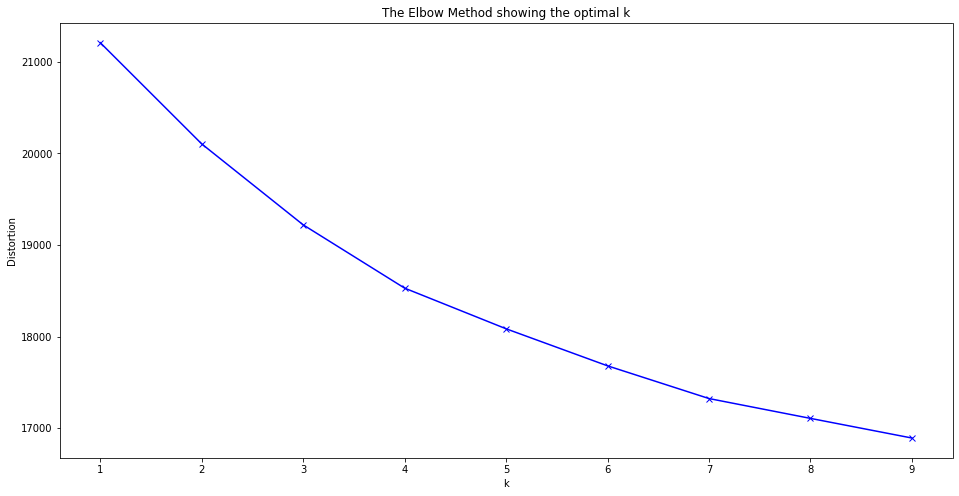

In [90]:
get_elbow_graph(corpus_embeddings)

In [103]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=4, corpus_df=merged_df)
cluster_1_tweets_list = cluster_tweets[0]
cluster_2_tweets_list = cluster_tweets[1]
cluster_3_tweets_list = cluster_tweets[2]
cluster_4_tweets_list = cluster_tweets[3]


In [104]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

,cluster,score
0,0,0.994957
1,1,0.995086
2,2,0.995022
3,3,0.995087


In [66]:
cluster_1_tweets_list

['Got kicked off the beach yesterday time for round two 😂😂',
 'Got really sick today. My mom, second mom and boyfriend helped me get through the day. Love them all.',
 "Got flipped off this morning. Obviously it's going to be a good day.",
 '@Greasy_Panic Glad it wasn’t just Me. Got booted off my PS4 last night . And internet hasn’t worked since',
 'So I just got fired LMFAOO',
 "Got laid off today. Next Friday will be my last day.  I'm sad & very stressed, but the xanax & ice cream are making me feel a little better.",
 'I got caught in the rain yesterday. It was such a bummer.',
 'Got pulled over today, cop let me off with a warning.  Cool.',
 'Wow I got fried today',
 'I got in a car wreck today. Great. https://t.co/MqSJXa4oud',
 "I got let go today and I'm really sad now",
 'I got laid today https://t.co/FZXIKzKtbN',
 'I literally jumped ship yesterday.',
 "I got laid last night. And I get some tomorrow because it's my birthday. Damn.",
 'Apparently I got hacked last week. Thanks t

In [106]:
get_most_common_ngrams(cluster_1_tweets_list, n=2, topk=20)

[(('lost', 'my'), 57),
 (('just', 'lost'), 47),
 (('i', 'lost'), 32),
 (('i', 'just'), 27),
 (('lost', 'power'), 23),
 (('got', 'lost'), 22),
 (('last', 'night'), 18),
 (('t', 'co'), 15),
 (('my', 'phone'), 14),
 (('just', 'got'), 13),
 (('today', 'i'), 11),
 (('lost', 'it'), 9),
 (('i', 'got'), 8),
 (('my', 'job'), 7),
 (('so', 'i'), 7),
 (('lost', 'in'), 7),
 (('i', 'm'), 7),
 (('my', 'voice'), 6),
 (('lost', 'today'), 6),
 (('my', 'wallet'), 5)]

In [107]:
get_most_common_ngrams(cluster_2_tweets_list, n=2, topk=20)

[(('i', 'got'), 83),
 (('just', 'got'), 42),
 (('got', 'fired'), 26),
 (('got', 'laid'), 22),
 (('i', 'm'), 22),
 (('i', 'just'), 21),
 (('last', 'night'), 19),
 (('laid', 'off'), 17),
 (('today', 'i'), 16),
 (('and', 'i'), 16),
 (('t', 'co'), 15),
 (('off', 'today'), 12),
 (('got', 'called'), 12),
 (('called', 'off'), 12),
 (('today', 'and'), 10),
 (('so', 'i'), 10),
 (('got', 'dumped'), 9),
 (('got', 'pulled'), 8),
 (('pulled', 'over'), 8),
 (('out', 'of'), 8)]

In [108]:
get_most_common_ngrams(cluster_3_tweets_list, n=2, topk=20)

[(('just', 'got'), 154),
 (('out', 'of'), 126),
 (('got', 'out'), 79),
 (('got', 'kicked'), 54),
 (('kicked', 'out'), 52),
 (('i', 'just'), 31),
 (('of', 'the'), 26),
 (('of', 'my'), 17),
 (('i', 'got'), 16),
 (('of', 'school'), 11),
 (('t', 'co'), 11),
 (('got', 'home'), 10),
 (('locked', 'out'), 10),
 (('my', 'house'), 10),
 (('the', 'hospital'), 10),
 (('of', 'bed'), 10),
 (('got', 'locked'), 9),
 (('i', 'm'), 9),
 (('last', 'night'), 8),
 (('of', 'a'), 7)]

In [109]:
get_most_common_ngrams(cluster_4_tweets_list, n=2, topk=20)

[(('just', 'got'), 168),
 (('i', 'just'), 89),
 (('got', 'pulled'), 25),
 (('pulled', 'over'), 25),
 (('got', 'pissed'), 22),
 (('pissed', 'off'), 18),
 (('got', 'fired'), 11),
 (('t', 'co'), 10),
 (('got', 'dumped'), 10),
 (('the', 'fuck'), 7),
 (('just', 'fell'), 7),
 (('got', 'laid'), 6),
 (('no', 'reason'), 5),
 (('fell', 'out'), 5),
 (('got', 'hit'), 5),
 (('out', 'of'), 4),
 (('and', 'i'), 4),
 (('well', 'i'), 4),
 (('i', 'm'), 4),
 (('for', 'the'), 4)]

In [26]:
list_1=get_most_common_ngrams(cluster_1_tweets_list, n=4, topk=20)

In [27]:
list_2=get_most_common_ngrams(cluster_2_tweets_list, n=4, topk=20)

In [28]:
get_most_common_ngrams(cluster_2_tweets_list, n=2, topk=20)[0][0]

('i', 'got')

In [29]:
def difference_ngrams(list_1, list_2, n):
    if len(list_1) == len(list_2):
        list_ngram_1 = list()
        list_ngram_2 = list()
        for ngram_block in list_1:
            list_ngram_1.append(ngram_block[0])
        for ngram_block in list_2:
            list_ngram_2.append(ngram_block[0])
        inter_list = list(set(list_ngram_1).intersection(list_ngram_2))
        print(f'{str(100*len(inter_list)/len(list_ngram_1))}% of {str(n)}-grams in common')
        print(f'*******{str(n)} grams in common:*******', *inter_list, sep='\n')
        print(f'*******{str(n)} grams specific to cluster 1:*******', *[ngram for ngram in list_ngram_1 if ngram not in inter_list], sep='\n')
        print(f'*******{str(n)} grams specific to cluster 2:*******', *[ngram for ngram in list_ngram_2 if ngram not in inter_list], sep='\n')


## is_hired_1mo:

In [131]:
merged_df = pd.read_parquet(os.path.join(output_path, 'is_hired_1mo.parquet'))

In [132]:
print(label2rank['is_hired_1mo'])

5970


In [133]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

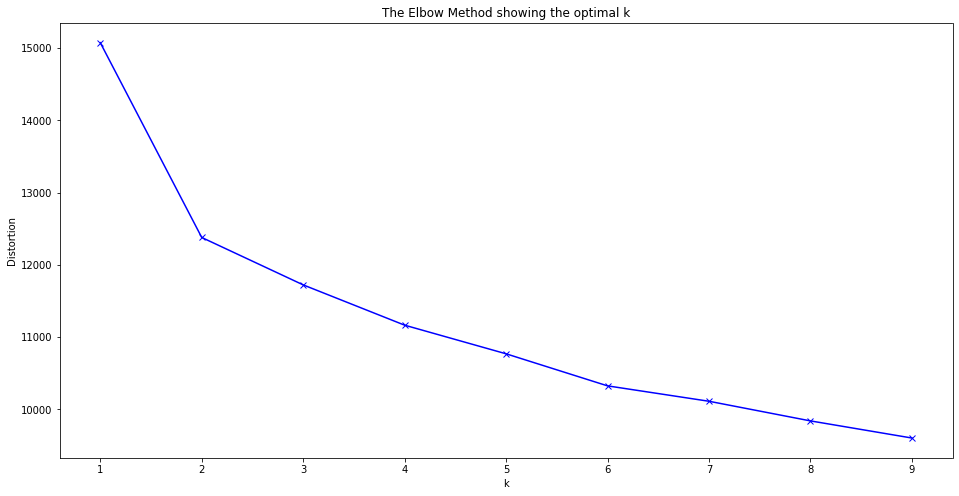

In [134]:
get_elbow_graph(corpus_embeddings)

In [135]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=2, corpus_df=merged_df)
cluster_1_tweets_list = cluster_tweets[0]
cluster_2_tweets_list = cluster_tweets[1]
# cluster_3_tweets_list = cluster_tweets[2]
# cluster_4_tweets_list = cluster_tweets[3]

In [136]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

,cluster,score
0,0,0.973546
1,1,0.973498


In [137]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

[(('my', 'new', 'job'), 294),
 (('start', 'my', 'new'), 228),
 (('i', 'start', 'my'), 130),
 (('new', 'job', 'tomorrow'), 103),
 (('new', 'job', 'today'), 57),
 (('to', 'start', 'my'), 54),
 (('my', 'first', 'day'), 33),
 (('new', 'job', 'on'), 31),
 (('a', 'new', 'job'), 26),
 (('wait', 'to', 'start'), 25),
 (('got', 'the', 'job'), 23),
 (('starting', 'my', 'new'), 23),
 (('can', 't', 'wait'), 22),
 (('first', 'day', 'of'), 22),
 (('first', 'day', 'at'), 20),
 (('at', 'my', 'new'), 20),
 (('start', 'my', 'first'), 20),
 (('t', 'wait', 'to'), 19),
 (('excited', 'to', 'start'), 19),
 (('job', 'on', 'monday'), 18)]

In [138]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

[(('got', 'the', 'job'), 124),
 (('i', 'got', 'the'), 83),
 (('a', 'new', 'job'), 45),
 (('got', 'a', 'new'), 43),
 (('just', 'got', 'hired'), 25),
 (('got', 'a', 'job'), 25),
 (('i', 'got', 'a'), 24),
 (('just', 'got', 'a'), 22),
 (('got', 'hired', 'at'), 18),
 (('i', 'just', 'got'), 18),
 (('yay', 'i', 'got'), 14),
 (('job', 'i', 'got'), 14),
 (('i', 'got', 'hired'), 12),
 (('the', 'job', 'i'), 12),
 (('got', 'hired', 'on'), 11),
 (('hired', 'on', 'the'), 11),
 (('new', 'job', 'today'), 8),
 (('on', 'the', 'spot'), 8),
 (('the', 'job', 'yay'), 7),
 (('finally', 'got', 'a'), 7)]

## is_unemployed

In [139]:
merged_df = pd.read_parquet(os.path.join(output_path, 'is_unemployed.parquet'))

In [140]:
print(label2rank['is_unemployed'])

3030


In [141]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

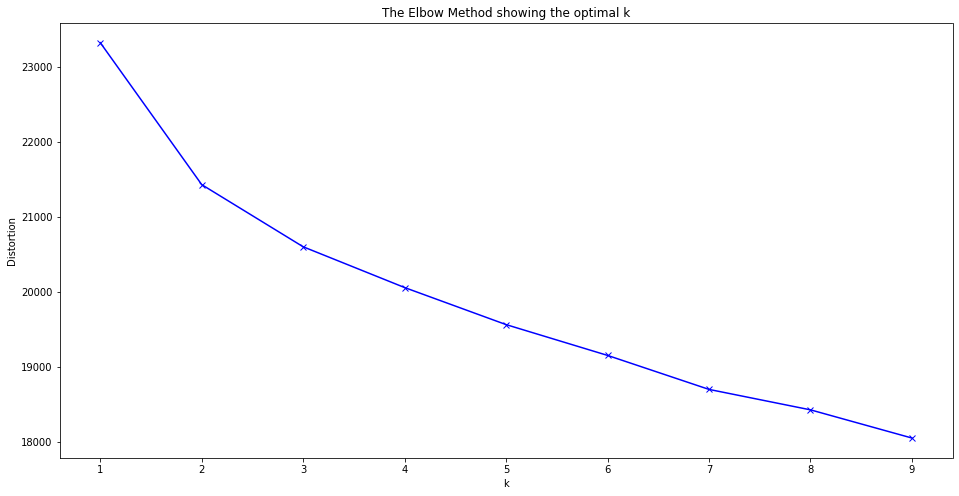

In [142]:
get_elbow_graph(corpus_embeddings)

In [143]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=2, corpus_df=merged_df)
cluster_1_tweets_list = cluster_tweets[0]
cluster_2_tweets_list = cluster_tweets[1]
# cluster_3_tweets_list = cluster_tweets[2]
# cluster_4_tweets_list = cluster_tweets[3]

In [144]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

,cluster,score
0,0,0.988563
1,1,0.988607


In [145]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

[(('i', 've', 'lost'), 78),
 (('ve', 'lost', 'my'), 44),
 (('i', 'lost', 'my'), 43),
 (('i', 'm', 'lost'), 29),
 (('lost', 'my', 'voice'), 27),
 (('i', 'just', 'lost'), 23),
 (('i', 'm', 'losing'), 22),
 (('m', 'losing', 'my'), 20),
 (('losing', 'my', 'voice'), 18),
 (('lost', 'my', 'phone'), 14),
 (('i', 've', 'been'), 12),
 (('just', 'lost', 'my'), 12),
 (('lost', 'my', 'mind'), 11),
 (('my', 'voice', 'i'), 10),
 (('losing', 'my', 'mind'), 10),
 (('im', 'losing', 'my'), 10),
 (('i', 'have', 'lost'), 9),
 (('lost', 'the', 'game'), 9),
 (('i', 'don', 't'), 9),
 (('just', 'lost', 'the'), 8)]

In [146]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

[(('i', 'need', 'a'), 61),
 (('i', 'have', 'a'), 31),
 (('i', 'm', 'in'), 31),
 (('need', 'a', 'job'), 30),
 (('i', 've', 'been'), 26),
 (('i', 'need', 'to'), 23),
 (('i', 'm', 'having'), 22),
 (('need', 'a', 'drink'), 20),
 (('and', 'i', 'm'), 20),
 (('in', 'need', 'of'), 16),
 (('right', 'now', 'i'), 15),
 (('have', 'a', 'headache'), 15),
 (('need', 'of', 'a'), 15),
 (('i', 'haven', 't'), 14),
 (('m', 'having', 'a'), 13),
 (('m', 'in', 'a'), 13),
 (('now', 'i', 'm'), 12),
 (('i', 'can', 't'), 11),
 (('m', 'in', 'need'), 11),
 (('i', 'need', 'food'), 9)]

## job_search:

In [147]:
merged_df = pd.read_parquet(os.path.join(output_path, 'job_search.parquet'))

In [148]:
print(label2rank['job_search'])

6190


In [149]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

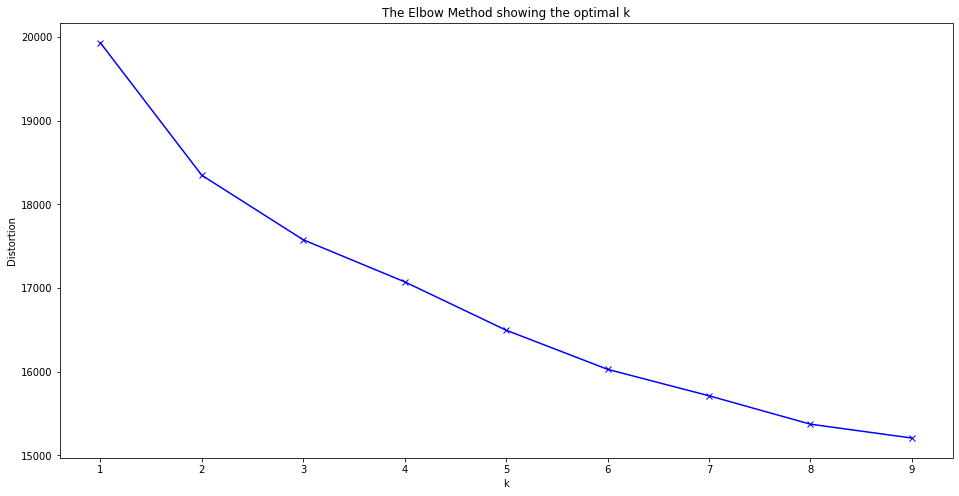

In [150]:
get_elbow_graph(corpus_embeddings)

In [151]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=2, corpus_df=merged_df)
cluster_1_tweets_list = cluster_tweets[0]
cluster_2_tweets_list = cluster_tweets[1]
# cluster_3_tweets_list = cluster_tweets[2]
# cluster_4_tweets_list = cluster_tweets[3]

In [152]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

,cluster,score
0,0,0.997854
1,1,0.997852


In [153]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

[(('i', 'need', 'a'), 158),
 (('need', 'a', 'job'), 90),
 (('a', 'new', 'job'), 51),
 (('hiring', 'i', 'need'), 48),
 (('need', 'a', 'new'), 41),
 (('looking', 'for', 'a'), 33),
 (('for', 'a', 'job'), 30),
 (('a', 'second', 'job'), 27),
 (('job', 'i', 'need'), 24),
 (('need', 'a', 'second'), 20),
 (('who', 's', 'hiring'), 19),
 (('i', 'need', 'to'), 18),
 (('anyone', 'know', 'of'), 18),
 (('a', 'job', 'i'), 15),
 (('know', 'of', 'any'), 14),
 (('let', 'me', 'know'), 14),
 (('job', 'anyone', 'know'), 13),
 (('if', 'anyone', 'knows'), 13),
 (('a', 'job', 'anyone'), 12),
 (('i', 'm', 'looking'), 12)]

In [154]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

[(('i', 'need', 'a'), 500),
 (('need', 'a', 'job'), 230),
 (('a', 'new', 'job'), 219),
 (('need', 'a', 'new'), 201),
 (('job', 'i', 'need'), 129),
 (('i', 'need', 'to'), 101),
 (('a', 'second', 'job'), 63),
 (('need', 'another', 'job'), 63),
 (('i', 'need', 'another'), 62),
 (('need', 'a', 'second'), 60),
 (('need', 'to', 'find'), 60),
 (('a', 'job', 'i'), 58),
 (('new', 'job', 'i'), 55),
 (('to', 'find', 'a'), 42),
 (('job', 'asap', 'i'), 31),
 (('asap', 'i', 'need'), 29),
 (('need', 'to', 'get'), 28),
 (('a', 'job', 'asap'), 26),
 (('find', 'a', 'job'), 21),
 (('new', 'job', 'asap'), 20)]

## job_offer

In [155]:
merged_df = pd.read_parquet(os.path.join(output_path, 'job_offer.parquet'))

In [156]:
print(label2rank['job_offer'])

88201


In [157]:
text_list = clean_tweets(merged_df['text'].tolist())
corpus_embeddings = model.encode(text_list, show_progress_bar=True, convert_to_numpy=True)

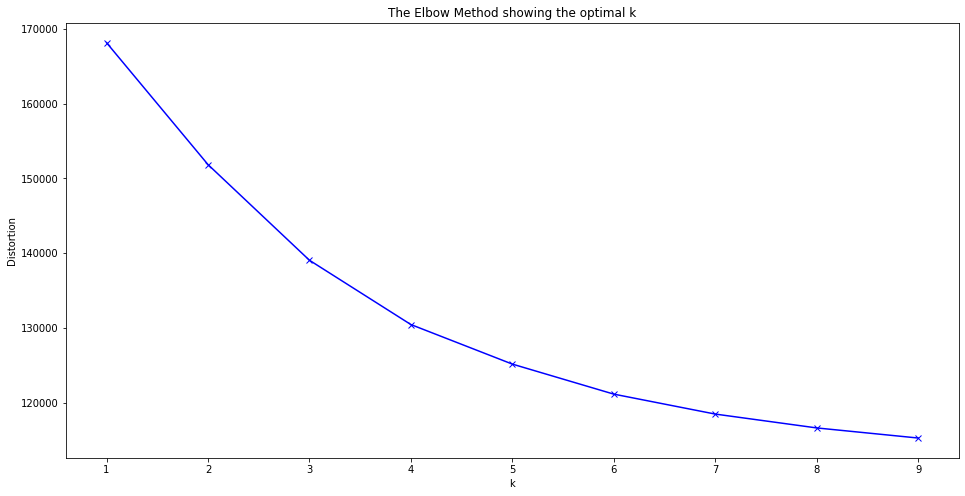

In [158]:
get_elbow_graph(corpus_embeddings)

In [159]:
cluster_tweets, merged_df['cluster'] = perform_k_means(corpus_embeddings, num_clusters=4, corpus_df=merged_df)
cluster_1_tweets_list = cluster_tweets[0]
cluster_2_tweets_list = cluster_tweets[1]
cluster_3_tweets_list = cluster_tweets[2]
cluster_4_tweets_list = cluster_tweets[3]

In [160]:
merged_df.groupby('cluster', as_index=False)['score'].mean()

,cluster,score
0,0,0.997246
1,1,0.997235
2,2,0.997244
3,3,0.997240


In [161]:
get_most_common_ngrams(cluster_1_tweets_list, n=3, topk=20)

[(('click', 'to', 'apply'), 1630),
 (('we', 're', 'hiring'), 1594),
 (('re', 'hiring', 'click'), 1562),
 (('hiring', 'click', 'to'), 1562),
 (('careerarc', 'we', 're'), 911),
 (('jobs', 'careerarc', 'we'), 856),
 (('job', 'jobs', 'careerarc'), 566),
 (('jobs', 'we', 're'), 420),
 (('job', 'jobs', 'we'), 283),
 (('http', 't', 'co'), 262),
 (('technician', 't', 'co'), 99),
 (('ca', 'job', 'jobs'), 93),
 (('job', 'we', 're'), 75),
 (('to', 'apply', 'pharmacy'), 70),
 (('apply', 'pharmacy', 'technician'), 69),
 (('see', 'our', 'latest'), 68),
 (('job', 'and', 'click'), 68),
 (('and', 'click', 'to'), 68),
 (('veterans', 'job', 'jobs'), 65),
 (('manager', 't', 'co'), 65)]

In [162]:
get_most_common_ngrams(cluster_2_tweets_list, n=3, topk=20)

[(('job', 'might', 'be'), 549),
 (('might', 'be', 'a'), 549),
 (('be', 'a', 'great'), 549),
 (('a', 'great', 'fit'), 549),
 (('great', 'fit', 'for'), 549),
 (('fit', 'for', 'you'), 549),
 (('hiring', 'careerarc', 'this'), 379),
 (('this', 'job', 'might'), 286),
 (('careerarc', 'this', 'job'), 195),
 (('hiring', 'this', 'job'), 89),
 (('http', 't', 'co'), 66),
 (('ca', 'hiring', 'careerarc'), 41),
 (('this', 'retail', 'job'), 38),
 (('retail', 'job', 'might'), 38),
 (('this', 'healthcare', 'job'), 36),
 (('healthcare', 'job', 'might'), 36),
 (('manager', 't', 'co'), 34),
 (('tx', 'hiring', 'careerarc'), 31),
 (('this', 'hospitality', 'job'), 29),
 (('hospitality', 'job', 'might'), 29)]

In [163]:
get_most_common_ngrams(cluster_3_tweets_list, n=3, topk=20)

[(('anyone', 'for', 'this'), 1179),
 (('for', 'this', 'job'), 1179),
 (('can', 'you', 'recommend'), 1177),
 (('you', 'recommend', 'anyone'), 1177),
 (('recommend', 'anyone', 'for'), 1177),
 (('careerarc', 'can', 'you'), 731),
 (('hiring', 'careerarc', 'can'), 730),
 (('hiring', 'can', 'you'), 409),
 (('http', 't', 'co'), 157),
 (('technician', 't', 'co'), 67),
 (('retail', 'hiring', 'careerarc'), 53),
 (('this', 'job', 'store'), 50),
 (('manager', 't', 'co'), 50),
 (('healthcare', 'hiring', 'careerarc'), 49),
 (('this', 'job', 'assistant'), 42),
 (('ca', 'hiring', 'careerarc'), 41),
 (('fl', 'hiring', 'careerarc'), 35),
 (('associate', 't', 'co'), 33),
 (('this', 'job', 'senior'), 33),
 (('this', 'job', 'pharmacy'), 32)]

In [164]:
get_most_common_ngrams(cluster_4_tweets_list, n=3, topk=20)

[(('http', 't', 'co'), 2808),
 (('jobs', 'hiring', 'careerarc'), 522),
 (('job', 'now', 'hiring'), 437),
 (('i', 'm', 'hiring'), 397),
 (('now', 'hiring', 'for'), 327),
 (('is', 'looking', 'for'), 275),
 (('job', 'jobs', 'hiring'), 232),
 (('ca', 'http', 't'), 211),
 (('ny', 'http', 't'), 208),
 (('job', 'i', 'm'), 207),
 (('new', 'york', 'ny'), 204),
 (('tx', 'http', 't'), 187),
 (('in', 'new', 'york'), 166),
 (('looking', 'for', 'a'), 163),
 (('we', 're', 'hiring'), 148),
 (('york', 'ny', 'http'), 141),
 (('fl', 'http', 't'), 141),
 (('job', 'looking', 'for'), 133),
 (('hiring', 'careerarc', 'now'), 115),
 (('careerarc', 'now', 'hiring'), 115)]